# Dog Breed Classification Using Convolutional Neural Networks

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
import numpy as np
import math
import shutil

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Data Collection & Preperation

In [8]:
# original dataset path
src_dir = 'StanfordDogsDataset/Images/images/'

# new dataset path
dst_dir = 'data/'

# create destination folder if it doesn't exist
os.makedirs(dst_dir, exist_ok=True)

# get all dog breed categories
categories = os.listdir(src_dir)

for category in categories:
    # remove the numeric prefix and convert to lowercase
    cleaned_name = category.split('-', 1)[-1].lower()
    
    # create a folder for the dog breed
    breed_dst_path = os.path.join(dst_dir, cleaned_name)
    os.makedirs(breed_dst_path, exist_ok=True)
    
    # copy all images from the original folder to the cleaned folder
    category_src_path = os.path.join(src_dir, category)
    for file_name in os.listdir(category_src_path):
        src_file = os.path.join(category_src_path, file_name)
        dst_file = os.path.join(breed_dst_path, file_name)
        shutil.copy(src_file, dst_file)

120


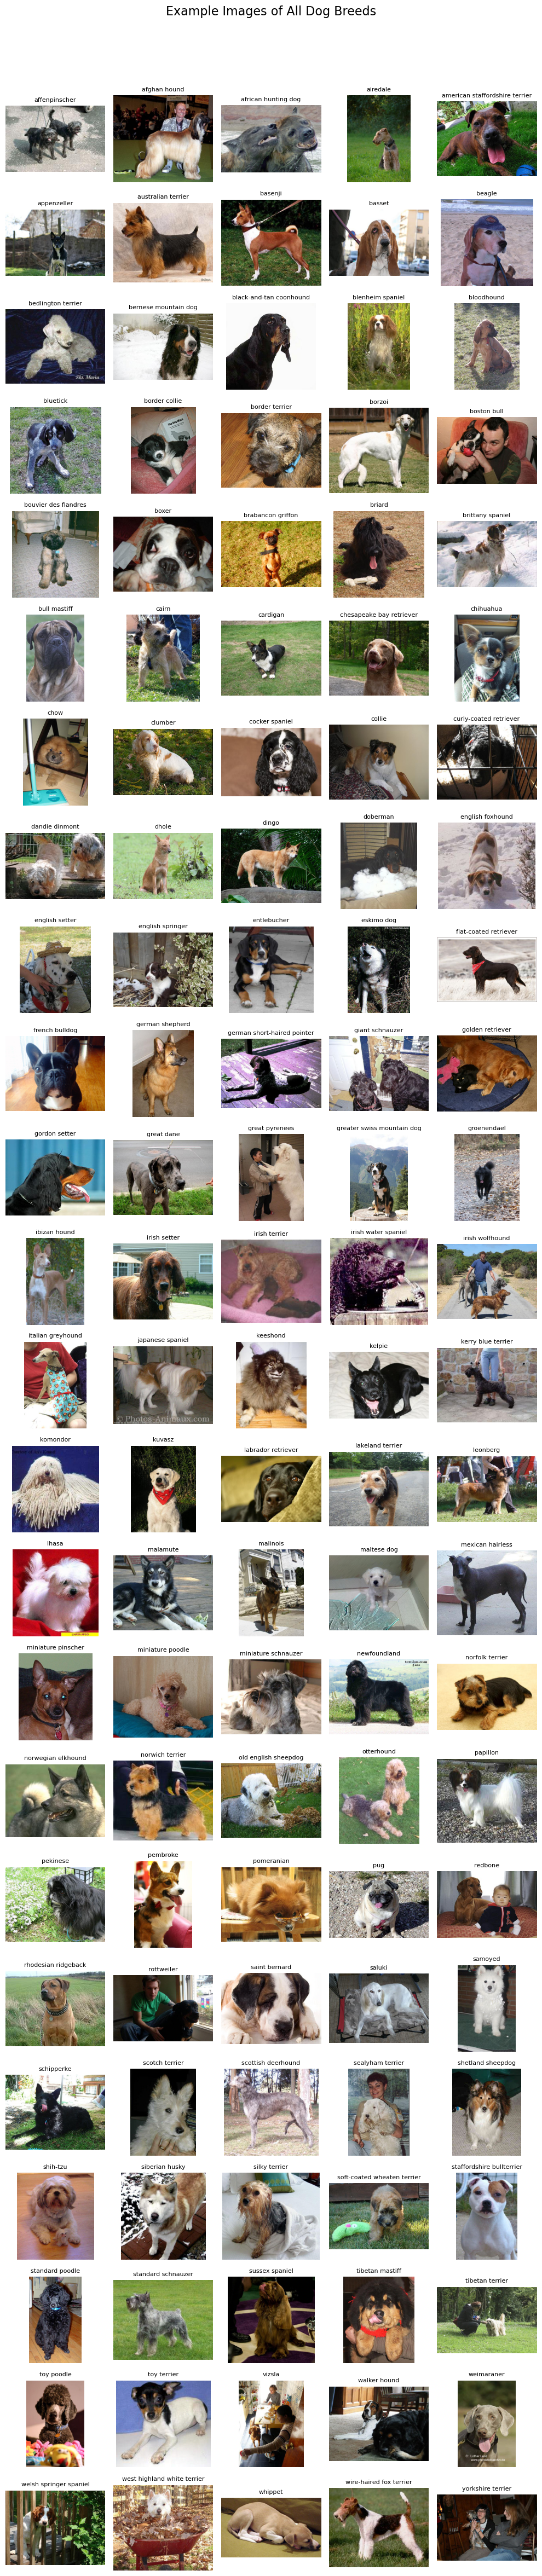

In [21]:
data_dir = 'data/'

# get all breeds
breeds = os.listdir(data_dir)
breeds.sort()  # optional: sort alphabetically
print(len(breeds))

# figure layout
num_breeds = len(breeds)
cols = 5  # number of columns per row
rows = math.ceil(num_breeds / cols)

fig = plt.figure(figsize=(cols * 2, rows * 2))
gs = gridspec.GridSpec(rows, cols)

# plot one image per breed
for idx, breed in enumerate(breeds):
    row = idx // cols
    col = idx % cols
    breed_path = os.path.join(data_dir, breed)
    image_list = os.listdir(breed_path)

    image = Image.open(os.path.join(breed_path, image_list[0])).convert('RGB')

    ax = fig.add_subplot(gs[row, col])
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(breed.replace('_', ' '), fontsize=8)

plt.suptitle('Example Images of All Dog Breeds', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [16]:
# training transform with augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# validation/test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [17]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# override transforms for val/test
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform


In [18]:
# this function bundles up the training/testing loops from the previous notebook
def training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True):
    # make empty lists to keep track of the training and testing losses
    train_losses = []
    test_losses = []
    
    # loop through each epoch to run the training loop
    # and check the model with the training data
    # keep track of both sets of losses as your go
    for epoch in range(NUM_EPOCHS):
        
        # Run the training loop
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_images = 0
        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_inputs)
            train_correct, train_total = compute_correct_labels(outputs, train_labels)
            total_train_correct += train_correct
            total_train_images += train_total
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Run the testing loop
        # this is essentially the same as the training loop but
        # without the optimizer and backward propagation
        model.eval()
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_images = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                test_correct, test_total = compute_correct_labels(outputs, test_labels)
                total_test_correct += test_correct
                total_test_images += test_total
                loss = criterion(outputs, test_labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if printing:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
                  f" - Train Loss: {avg_train_loss:.4f}, "+\
                  f"Train Correct: {total_train_correct}/{total_train_images} "+\
                  f"- Test Loss: {avg_test_loss:.4f}, "+\
                  f"Test Correct: {total_test_correct}/{total_test_images} ")

    return(train_losses, test_losses)

Finally, let's redefine the cross entropy loss function

In [19]:
# cross entropy loss for use in classification problems
criterion = nn.CrossEntropyLoss()

In [27]:
def compute_correct_labels(outputs, labels):
    correct = 0
    total = 0
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        if differences[i]==0:
            correct +=1
        total += 1
    return(correct, total)

In [24]:
# this class is identical to that used in the previous notebook
# add a dropout layer in the fully connected layers of the notebook
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # added third conv layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        conv_output_size = 64 * (32) * (32)
        self.fc_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(conv_output_size, 128), 
            nn.ReLU(),

            # add a dropout layer here
            nn.Dropout(p=0.3),
            
            nn.Linear(128, 120)
        )

    # define the forward step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

With this change, we can procede to training our model using our training function:

In [28]:
# redefine the model here in case cells are run 
# out of order for instructional purposes
model = ClassificationCNN().to(device)

# Adam optimizer for stochastic gradient descent
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
NUM_EPOCHS = 30

# call the training loop function we defined above
train_losses, test_losses = training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True)

Epoch 1/30 - Train Loss: 4.7831, Train Correct: 170/16464 - Test Loss: 4.7588, Test Correct: 24/2058 
Epoch 2/30 - Train Loss: 4.6435, Train Correct: 327/16464 - Test Loss: 4.5582, Test Correct: 45/2058 
Epoch 3/30 - Train Loss: 4.4968, Train Correct: 520/16464 - Test Loss: 4.4119, Test Correct: 76/2058 
Epoch 4/30 - Train Loss: 4.2530, Train Correct: 953/16464 - Test Loss: 4.2878, Test Correct: 107/2058 
Epoch 5/30 - Train Loss: 3.9490, Train Correct: 1634/16464 - Test Loss: 4.2653, Test Correct: 136/2058 
Epoch 6/30 - Train Loss: 3.4705, Train Correct: 2832/16464 - Test Loss: 4.4471, Test Correct: 138/2058 
Epoch 7/30 - Train Loss: 2.7732, Train Correct: 4896/16464 - Test Loss: 4.7489, Test Correct: 126/2058 
Epoch 8/30 - Train Loss: 2.0741, Train Correct: 7252/16464 - Test Loss: 5.4671, Test Correct: 126/2058 
Epoch 9/30 - Train Loss: 1.5396, Train Correct: 9211/16464 - Test Loss: 6.0260, Test Correct: 114/2058 
Epoch 10/30 - Train Loss: 1.2122, Train Correct: 10549/16464 - Test Los

KeyboardInterrupt: 

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 800x400 with 0 Axes>